In [9]:
using Printf, JLD2
include("../code/headers.jl")

# BP with decimation

In [10]:
function performance(fg::FactorGraph, s)
    σ = sign.(fg.fields)
    x = σ .== -1
    nunsat = sum(fg.H*x .% 2)
    ovl = dot(σ, sign.(s))/fg.n
    dist = (1-ovl)/2
    nunsat, ovl, dist
end

performance (generic function with 2 methods)

In [11]:
function decimate!(fg, s, free=collect(1:fg.n); Tmax=10, kw...)
    freevars = copy(free)
    for t in 1:Tmax
        copy!(free, freevars)
        nunsat, ovl, dist = decimate1!(fg, s, freevars; kw...)
        str = nunsat==-1 ? "contradiction found" : "$nunsat unsat"
        print("# Trial $t of $Tmax: ", str)
        if nunsat == 0 
            if all(sign.(fg.fields) .!= 0)
                println()
                return nunsat, ovl, dist
            else
               print(" but ", sum(sign.(fg.fields).==0), " undecided") 
            end
        end
        println()
    end
    println("No zero-unsat found after $Tmax trials")
    nunsat, ovl, dist
end

decimate! (generic function with 2 methods)

In [12]:
function decimate1!(fg, s, freevars; ndec=1, maxiter=200, F=Inf*fg.n, verbose=true, tol=1e-12, kw_bp...)
    ε = 0.0
    for f in 1:m
        fg.mfv[f] .= zeros(length(fg.mfv[f])) 
    end
    fg.fields .= copy(s)        
    for it in 1:maxiter
        ε = onebpiter!(fg, BP(); kw_bp...) 
    end
    cnt = 1
    iters = 0
    while !isempty(freevars)
        sort!(freevars, by=j->abs(fg.fields[j]))
        freevars, tofix = freevars[1:end-ndec], freevars[max(1,end-ndec+1):end]
        fg.fields[tofix] .= F*sign.(fg.fields[tofix])
        for it in 1:maxiter
            ε = onebpiter!(fg, BP(); kw_bp...)
            ε == -1.0 && return -1, NaN, NaN
            if ε < tol; (iters = it; break) else; iters=maxiter end
        end
        nunsat, ovl, dist = performance(fg, s)
        if verbose 
            @printf(" Step %3d. ε = %6.2E. Unsat = %3d. Free = %3d. Ovl = %.3f. Iters %d\n", 
                cnt, ε, nunsat, length(freevars), ovl, iters)
        end
        nunsat == 0 && return nunsat, ovl, dist
        cnt += 1
    end
    nunsat, ovl, dist
end

decimate1! (generic function with 1 method)

## 1. Variables of degree 2

In [13]:
n = 1000
R = 0.25
m = round(Int,n*(1-R))
fg = ldpc_graphGF2(n,m)
H = 1e-3
s = rand((-1,1), n)
fg.fields .= H*copy(s)
basis, indep = lightbasis(fg)
freevars = findall(indep);

In [14]:
nunsat, ovl, dist = decimate!(fg, s, freevars, maxiter=100, verbose=false) 

# Trial 1 of 10: 0 unsat


(0, 0.486, 0.257)

In [15]:
lm = LossyModel(fg, y=(s.==-1))
res = solve!(lm, OptimalCycle())
dist_oc = res.distortion

Iter 1. Distortion 0.257. Cycle weight -490.0. Energy shift -245.0
Iter 2. Distortion 0.257. Cycle weight 0.0. Energy shift 0.0


0.257

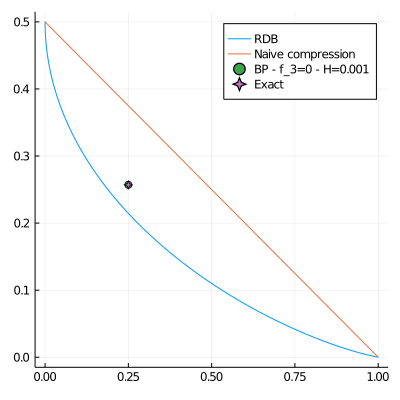

In [16]:
pl = plot_rdb()
scatter!([R], [dist], label="BP - f_3=0 - H=$H")
scatter!([R], [dist_oc], label="Exact", marker=:star4)
plot(pl, size=(400,400))

### 1.1 Varying H

In [ ]:
n = 1000
R = 0.25
m = round(Int,n*(1-R))
fg = ldpc_graphGF2(n,m)
_, indep = lightbasis(fg)
freevars = findall(indep)
s = rand((-1,1), n)
Hs = 10.0 .^ (-7:2:3)
dist_f2 = zeros(length(Hs))
for (i,H) in enumerate(Hs)
    println("------ H=", H, ". ", i, " of ", length(Hs), " ------")
    fg.fields .= H*copy(s)
    for f in 1:fg.m; fg.mfv[f] .= 0.0 end
    nunsat, ovl, dist_f2[i] = decimate!(fg, s, freevars, maxiter=50, verbose=false) 
    println()
end
lm = LossyModel(fg, y=(s.==-1))
res = solve!(lm, OptimalCycle(), verbose=false)
dist_oc_ = res.distortion

In [ ]:
println("Min distortion achieved at H=", Hs[argmin(dist_f2)])
colors = cgrad(:heat, length(Hs)+1, categorical = true)
pl_f2 = plot_rdb()
for (i,H) in enumerate(Hs)
    scatter!(pl_f2, [R], [dist_f2[i]], label="BP - f_2=$(round(r,digits=1)) - H=$(round(H,sigdigits=1))", mc=colors[i])
end
plot(pl_f2, size=(400,400), legend=:topleft)
xlims!((0.15,0.35)); ylims!((0.2,0.3))

In [ ]:
[Hs dist_f2]

## 2. Mixture 2-3 variable degree

In [ ]:
m = factorial(7)÷6*7÷8
R = 0.25
r = 1 - 3R
n = round(Int, 3m/(2+r))
Λ = OffsetVector([0,0,1-r,r], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
nedges = 3m
# convert to edge degree convention to express the degree profile
lambda, rho = nodes2edges(Λ[1:end], K[1:end])
# build graph
fg = ldpc_graphGF2(n,m,nedges,lambda,rho)
H = 1e-5
s = H*rand((-1,1), n)
fg.fields .= copy(s)
basis, freevars = findbasis_slow(Array(fg.H))

In [ ]:
length(freevars), n, m

In [ ]:
nunsat, ovl, dist2 = decimate!(fg, s, freevars, maxiter=100, verbose=false) 

In [ ]:
pl2 = deepcopy(pl)
scatter!(pl2, [R], [dist2], marker=:diamond, label="BP - f_3=$r - H=$H")
plot(pl2, size=(400,400))
xlims!((0.15,0.35)); ylims!((0.15,0.35))

### 2.1 Varying H

In [ ]:
m = factorial(7)÷6*7÷8
R = 0.3
r = 1 - 3R
n = round(Int, 3m/(2+r))
Λ = OffsetVector([0,0,1-r,r], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
nedges = 3m
lambda, rho = nodes2edges(Λ[1:end], K[1:end])
Hs3 = 10.0 .^ (-1:2:3)
# Hs3 = [10.0^(-7)]
navg = 1
for j in 1:navg
    println("#### Round $j of $navg")
    fg = ldpc_graphGF2(n,m,nedges,lambda,rho)
    _, freevars = findbasis_slow(Array(fg.H))
    s = rand((-1,1), n)
    dist_f3 = zeros(length(Hs3))
    for (i,H) in enumerate(Hs3)
        println("------ H=", H, ". ", i, " of ", length(Hs3), " ------")
        fg.fields .= H*copy(s)
        for f in 1:fg.m; fg.mfv[f] .= 0.0 end
        _,_,d = decimate!(fg, s, freevars, maxiter=2000, Tmax=20, verbose=true, tol=1e-12) 
        dist_f3[i] += d 
    end
   dist_f3 ./= navg 
end

In [ ]:
println("Min distortion achieved at H=", Hs3[argmin(dist_f3)], ". Avg over $navg instances")
colors = cgrad(:heat, length(Hs3)+1, categorical = true)
pl_f3 = plot_rdb()
for (i,H) in enumerate(Hs3)
    scatter!(pl_f3, [R], [dist_f3[i]], label="BP - f_3=$(round(r,digits=1)) - H=$(round(H,sigdigits=1))", mc=colors[i])
end
Rm = 0.01:0.01:0.99
JLD2.@load "RS_dist.jld" Dm
plot!(pl_f3, Rm, Dm, lc=:gray, ls=:dash, label="RS")
plot(pl_f3, size=(400,400), legend=:topleft)
xlims!((0.15,0.35)); ylims!((0.2,0.3))

In [ ]:
[Hs3 dist_f3]